# Poisson Baseball

Adapted from http://pyro.ai/examples/bayesian_regression_ii.html

In [1]:
import logging
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from torch.distributions import constraints
from torch.nn.functional import softplus

import pyro
import pyro.distributions as dist
from pyro.infer import EmpiricalMarginal, SVI, Trace_ELBO, JitTrace_ELBO
from pyro.contrib.autoguide import AutoMultivariateNormal
from pyro.infer.mcmc.api import MCMC
from pyro.infer.mcmc import NUTS
import pyro.optim as optim

pyro.set_rng_seed(1)
assert pyro.__version__.startswith('0.4.1')

In [14]:
%matplotlib inline
logging.basicConfig(format='%(message)s', level=logging.INFO)
# Enable validation checks
pyro.enable_validation(True)
smoke_test = ('CI' in os.environ)
pyro.set_rng_seed(1)

In [2]:
data = pd.read_csv('all2018.csv', header = None).iloc[:,0:97]
headers = pd.read_csv('EventFields.csv')
data.columns = headers.Headers.values

/Users/Sam/.pyenv/versions/probprog/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (63,64,65,84,85) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
boolean_cols = data.filter(regex = '_FL$').columns
data.loc[:,boolean_cols] = data.loc[:,boolean_cols].replace({'T':True,'F':False})

In [4]:
# Create base state
data['base_state'] =  data.BASE1_RUN_ID.notnull().replace({True:'1', False:'_'})+\
                         data.BASE2_RUN_ID.notnull().replace({True:'2', False:'_'})+\
                         data.BASE3_RUN_ID.notnull().replace({True:'3', False:'_'})
data['base_out_state'] = data['base_state']+'_'+ data.OUTS_CT.astype(str) 
data['BAT_SCORE_CT'] = np.where(data.BAT_HOME_ID==1, data.HOME_SCORE_CT, data.AWAY_SCORE_CT)
data['END_OUTS_CT'] = data.OUTS_CT + data.EVENT_OUTS_CT

In [5]:
data_full_inn = (data.groupby(['GAME_ID', 'INN_CT','BAT_HOME_ID'])
    .filter(lambda x: (x['END_OUTS_CT']==3).any()))

In [6]:
data_full_inn['END_BAT_SCORE_CT'] = data_full_inn.groupby(['GAME_ID', 'INN_CT','BAT_HOME_ID'])['BAT_SCORE_CT'].transform('last')
data_full_inn['score_remaining'] = data_full_inn['END_BAT_SCORE_CT']-data_full_inn['BAT_SCORE_CT']

/Users/Sam/.pyenv/versions/probprog/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/Sam/.pyenv/versions/probprog/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [7]:
data_full_inn = data_full_inn.sample(frac = .25)

In [8]:
RE_MAT = (data_full_inn.groupby(['base_state','OUTS_CT'])['score_remaining']
    .mean().reset_index()
    .pivot_table(index = 'base_state', columns = 'OUTS_CT', values = 'score_remaining')
    .round(3))

RE_MAT

OUTS_CT,0,1,2
base_state,,,
123,2.275,1.527,0.730
12_,1.500,0.860,0.406
1_3,1.910,1.295,0.501
1__,0.875,0.532,0.214
_23,1.690,1.344,0.435
_2_,1.128,0.683,0.295
__3,1.462,0.993,0.343
___,0.505,0.261,0.090


## Bayesian Poisson Regression


## Model + Guide

We will write out the model again, similar to that in [Part I](bayesian_regression.ipynb), but explicitly without the use of `nn.Module`.  We will write out each term in the regression, using the same priors. `bA` and `bR` are regression coefficients corresponding to  `is_cont_africa` and `ruggedness`, `a` is the intercept, and `bAR` is the correlating factor between the two features.

Writing down a guide will proceed in close analogy to the construction of our model, with the key difference that the guide parameters need to be trainable. To do this we register the guide parameters in the ParamStore using `pyro.param()`. Note the positive constraints on scale parameters.

In [9]:
# Prepare data for pytorch
#All dummy values
dummies= pd.get_dummies(data_full_inn.base_out_state)
state_names = dummies.columns
states = torch.tensor(dummies.values, dtype=torch.float)
runs = torch.tensor(data_full_inn.score_remaining.values, dtype=torch.float)
pyro.clear_param_store()

In [23]:
state_names

Index(['123_0', '123_1', '123_2', '12__0', '12__1', '12__2', '1_3_0', '1_3_1',
       '1_3_2', '1___0', '1___1', '1___2', '_23_0', '_23_1', '_23_2', '_2__0',
       '_2__1', '_2__2', '__3_0', '__3_1', '__3_2', '____0', '____1', '____2'],
      dtype='object')

In [10]:
def model(states, runs):
    
    coef={}
    for s in state_names:
        coef[s] = pyro.sample(s, dist.Normal(.45, 1))
    
    log_lmbda = 0
    for i in range(len(state_names)):
        log_lmbda += coef[state_names[i]]*states[:,i]
    
    lmbda = log_lmbda.exp()
    
    with pyro.plate("data", len(runs)):
        y = pyro.sample("obs", dist.Poisson(lmbda), obs=runs)
    
    return y

In [15]:
def guide(states, runs):
    weights_loc = pyro.param('weights_loc', torch.randn(states.shape[1])+.45)
    weights_scale = pyro.param('weights_scale', torch.ones(states.shape[1]), 
                               constraint=constraints.positive)        
    
    coef = {}
    for i in range(len(state_names)):
        s = state_names[i]
        coef[s] = pyro.sample(s, dist.Normal(weights_loc[i], weights_scale[i]))
    
    log_lmbda = 0
    for i in range(len(state_names)):
        log_lmbda += coef[state_names[i]]*states[:,i]
        
    lmbda = log_lmbda.exp()

In [16]:
# Utility function to print latent sites' quantile information.
def summary(samples):
    site_stats = {}
    for site_name, values in samples.items():
        marginal_site = pd.DataFrame(values)
        describe = marginal_site.describe(percentiles=[.05, 0.25, 0.5, 0.75, 0.95]).transpose()
        site_stats[site_name] = describe[["mean", "std", "5%", "25%", "50%", "75%", "95%"]]
    return site_stats

## SVI

As before, we will use SVI to perform inference.

In [17]:
pyro.clear_param_store()
svi = SVI(model, 
          guide, 
          optim.Adam({"lr": .005}), 
          loss=JitTrace_ELBO(), 
          num_samples=1000)

pyro.clear_param_store()
num_iters = 10000 if not smoke_test else 2
for i in range(num_iters):
    elbo = svi.step(states, runs)
    if i % 500 == 0:
        logging.info("Elbo loss: {}".format(elbo))

/Users/Sam/.pyenv/versions/probprog/lib/python3.7/site-packages/ipykernel_launcher.py:13: TracerWarning: Converting a tensor to a Python index might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  del sys.path[0]
Elbo loss: 368129.53125
Elbo loss: 76322.5078125
Elbo loss: 64047.40234375
Elbo loss: 64358.83984375
Elbo loss: 55739.86328125
Elbo loss: 53189.2578125
Elbo loss: 51262.7421875
Elbo loss: 50278.44921875
Elbo loss: 46407.71875
Elbo loss: 46489.671875
Elbo loss: 46064.77734375
Elbo loss: 45081.8046875
Elbo loss: 45430.51171875
Elbo loss: 44933.23828125
Elbo loss: 44948.8359375
Elbo loss: 44981.015625
Elbo loss: 44942.49609375
Elbo loss: 44902.13671875
Elbo loss: 44899.94921875
Elbo loss: 44901.34375


In [18]:
svi_diagnorm_posterior = svi.run(states, runs)

Let us observe the posterior distribution over the different latent variables in the model.

In [19]:
svi_samples = {s: EmpiricalMarginal(svi_diagnorm_posterior, sites = s)
                     .enumerate_support().detach().cpu().numpy()
               for s in state_names}

for site, values in summary(svi_samples).items():
    print("Site: {}".format(site))
    print(np.exp(values), "\n")

Site: 123_0
       mean       std        5%       25%      50%       75%       95%
0  2.317859  1.053036  2.123747  2.243264  2.31966  2.397665  2.516123 

Site: 123_1
       mean      std        5%      25%       50%       75%       95%
0  1.522285  1.03869  1.429291  1.48337  1.522077  1.564662  1.616208 

Site: 123_2
       mean       std        5%       25%       50%       75%       95%
0  0.740579  1.052017  0.680834  0.715814  0.738691  0.770008  0.803228 

Site: 12__0
       mean       std        5%       25%       50%       75%       95%
0  1.493237  1.033093  1.415623  1.463582  1.491769  1.524566  1.576028 

Site: 12__1
       mean       std       5%      25%       50%       75%       95%
0  0.863335  1.032818  0.81999  0.84529  0.863045  0.882462  0.911049 

Site: 12__2
       mean       std        5%       25%       50%       75%       95%
0  0.407149  1.046096  0.377473  0.395515  0.407215  0.419345  0.437414 

Site: 1_3_0
       mean       std        5%       25%       50

## Comparing Posterior Distributions

Let us compare the posterior distribution of the latent variables that we obtained from variational inference with those from Hamiltonian Monte Carlo. As can be seen below, for Variational Inference, the marginal distribution of the different regression coefficients is under-dispersed w.r.t. the true posterior (from HMC). This is an artifact of the *KL(q||p)* loss (the KL divergence of the true posterior from the approximate posterior) that is minimized by Variational Inference.

This can be better seen when we plot different cross sections from the joint posterior distribution overlaid with the approximate posterior from variational inference. Note that since our variational family has diagonal covariance, we cannot model any correlation between the latents and the resulting approximation is overconfident (under-dispersed)

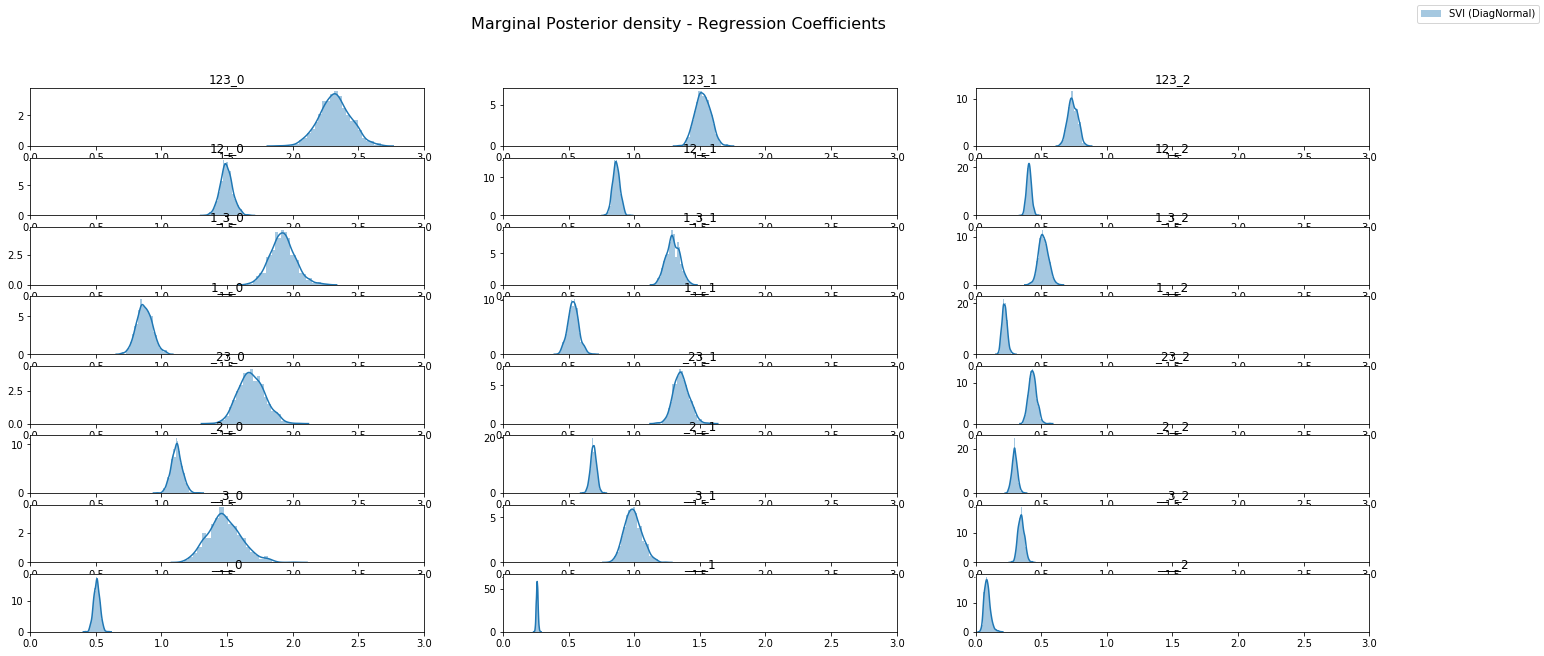

In [21]:
fig, axs = plt.subplots(nrows=8, ncols=3, figsize=(24, 10))
fig.suptitle("Marginal Posterior density - Regression Coefficients", fontsize=16)
for i, ax in enumerate(axs.reshape(-1)):
    try:
        site = state_names[i]
        #sns.distplot(hmc_samples[site], ax=ax, label="HMC")        
        sns.distplot(np.exp(svi_samples[site]), ax=ax, label="SVI (DiagNormal)")
        ax.set_title(site)
        ax.set_xlim(0,3)
    except:
        pass
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right');

In [24]:
1/2 + 1/3

0.8333333333333333